In [1]:
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 6.4 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import librosa
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Reshape
from tensorflow.keras.callbacks import ReduceLROnPlateau
from scikeras.wrappers import KerasClassifier

from kerastuner import RandomSearch
from keras.layers import Conv1D, MaxPooling2D,  AveragePooling1D, BatchNormalization
from keras.layers import Conv2D, MaxPooling1D, MaxPooling2D, Flatten, Dense, Dropout

<ipython-input-3-eebc219144ee>:23: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


In [ ]:

#ravdess_folder_path = "C:\Users\Manra\Documents\audio_speech_actors_01-24"

#with open(ravdess_folder_path, "r") as file:
 #   data = file.read()

In [4]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!cp -r /content/drive/MyDrive/'IE Project/audio_speech_actors_01-24'

In [ ]:
ravdess_folder_path = '/content/drive/MyDrive/audio_speech_actors_01-24'

In [ ]:
"""
def load_data_ravdess_raw_audio(directory):
    X = []
    y = []
    max_audio_length = 0
    
    for actor_dir in os.listdir(directory):
        actor_path = os.path.join(directory, actor_dir)
        if os.path.isdir(actor_path):
            for file in os.listdir(actor_path):
                if file.endswith(".wav"):
                    file_path = os.path.join(actor_path, file)
                    emotion = int(file.split("-")[2])
                    y.append(emotion)
                    
                    audio, sr = librosa.load(file_path, sr=None) # Loaded with original sampling rate
                    
                    max_audio_length = max(max_audio_length, len(audio))
                    
                    X.append(audio)
    
    X = [np.pad(x, (0, max_audio_length - len(x)), 'constant') if len(x) < max_audio_length else x[:max_audio_length] for x in X]
                    
    return np.array(X), np.array(y)
"""

'\ndef load_data_ravdess_raw_audio(directory):\n    X = []\n    y = []\n    max_audio_length = 0\n    \n    for actor_dir in os.listdir(directory):\n        actor_path = os.path.join(directory, actor_dir)\n        if os.path.isdir(actor_path):\n            for file in os.listdir(actor_path):\n                if file.endswith(".wav"):\n                    file_path = os.path.join(actor_path, file)\n                    emotion = int(file.split("-")[2])\n                    y.append(emotion)\n                    \n                    audio, sr = librosa.load(file_path, sr=None) # Loaded with original sampling rate\n                    \n                    max_audio_length = max(max_audio_length, len(audio))\n                    \n                    X.append(audio)\n    \n    X = [np.pad(x, (0, max_audio_length - len(x)), \'constant\') if len(x) < max_audio_length else x[:max_audio_length] for x in X]\n                    \n    return np.array(X), np.array(y)\n'

In [ ]:
#X, y = load_data_ravdess_raw_audio(ravdess_folder_path)

In [9]:
"""
import numpy as np
import random
from librosa.effects import time_stretch, pitch_shift

def add_noise(X, noise_factor=0.05):
    return X + noise_factor * np.random.randn(*X.shape)

def shift(X, shift_factor=1600):
    return np.roll(X, shift_factor)

def augment_data(X, y, noise_range=(0.005, 0.025), shift_range=(-400, 400), time_stretch_range=(0.8, 1.2), pitch_shift_range=(-2, 2), sr=22050, aug_prob=0.5):
    num_samples = X.shape[0]
    X_aug = np.zeros((num_samples,) + X.shape[1:])
    y_aug = np.zeros(num_samples)

    for i in range(num_samples):
        X_aug[i] = X[i]

        # Apply noise with probability
        if random.random() < aug_prob:
            noise_factor = random.uniform(noise_range[0], noise_range[1])
            X_aug[i] = add_noise(X_aug[i], noise_factor)

        # Apply shift with probability
        if random.random() < aug_prob:
            shift_factor = random.randint(shift_range[0], shift_range[1])
            X_aug[i] = shift(X_aug[i], shift_factor)

        y_aug[i] = y[i]

    # Concatenate original and augmented data
    X = np.concatenate((X, X_aug), axis=0)
    y = np.concatenate((y, y_aug), axis=0)

    return X, y
    """

In [45]:
import random
import numpy as np
import librosa

def add_noise(X, noise_factor=0.05):
    return X + noise_factor * np.random.randn(*X.shape)

def shift(X, shift_factor=1600):
    return np.roll(X, shift_factor)

import librosa

def augment_data(X, y, noise_range=(0.005, 0.025), shift_range=(-400, 400), time_stretch_range=(0.8, 1.2), pitch_shift_range=(-2, 2), sr=22050, aug_prob=0.5):
    num_samples = X.shape[0]
    X_aug = np.zeros((num_samples,) + X.shape[1:])
    y_aug = np.zeros(num_samples)

    for i in range(num_samples):
        x = X[i]

        # Apply noise with probability
        if random.random() < aug_prob:
            noise_factor = random.uniform(noise_range[0], noise_range[1])
            x = add_noise(x, noise_factor)

        # Apply shift with probability
        if random.random() < aug_prob:
            shift_factor = random.randint(shift_range[0], shift_range[1])
            x = shift(x, shift_factor)

        X_aug[i] = x[:X.shape[1]]  # Truncate or pad the result to match the original shape
        y_aug[i] = y[i]

    # Concatenate original and augmented data
    X = np.concatenate((X, X_aug), axis=0)
    y = np.concatenate((y, y_aug), axis=0)

    return X, y

In [46]:
X = np.load('/content/drive/MyDrive/X.npy')
y = np.load('/content/drive/MyDrive/y.npy')

In [47]:
X.shape

(1440, 253053)

In [48]:
# Augment the data
# Define the sampling rate (depending on your dataset)
sr = 22050

# Adjust the ranges and probabilities as needed
noise_range = (0.005, 0.025)
shift_range = (-400, 400)
aug_prob = 0.5

X, y = augment_data(X, y, noise_range=noise_range, shift_range=shift_range, sr=sr, aug_prob=aug_prob)

In [49]:
X.shape

(2880, 253053)

In [20]:
"""
# Normalize the data
scaler = MinMaxScaler()
X = scaler.fit_transform(X.reshape(X.shape[0], -1)).reshape(X.shape)

# One-hot encode the labels
encoder = OneHotEncoder()
y = encoder.fit_transform(y.reshape(-1, 1)).toarray()
"""

In [23]:
X.shape

(2880, 50)

In [24]:
y.shape

(2880, 8)

## **Feature Extraction**

In [19]:
"""
def extract_features_from_array(X, sr=44100):
    feature_list = []

    for audio_data in X:
        # Reshape audio data to 1D
        audio_data = audio_data.reshape(-1)

        # Preprocessing
        audio_data = librosa.effects.preemphasis(audio_data)
        audio_data = librosa.util.normalize(audio_data)

        # Mel spectrogram
        mel_spec = librosa.feature.melspectrogram(y=audio_data, sr=sr, n_mels=128, hop_length=512)
        log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

        # MFCCs
        mfcc = librosa.feature.mfcc(S=log_mel_spec, n_mfcc=13)

        # Chroma features
        chroma_stft = librosa.feature.chroma_stft(y=audio_data, sr=sr)

        # Spectral contrast
        spec_contrast = librosa.feature.spectral_contrast(y=audio_data, sr=sr)

        # Spectral centroid and bandwidth
        cent = librosa.feature.spectral_centroid(y=audio_data, sr=sr)
        bw = librosa.feature.spectral_bandwidth(y=audio_data, sr=sr)

        # Stack all features
        features = np.vstack([mfcc, chroma_stft, spec_contrast, cent, bw])

        feature_list.append(features)

    return np.array(feature_list)
    """

In [50]:
def extract_features_from_array(X, sr=44100):
    feature_list = []

    for audio_data in X:
        # Reshape audio data to 1D
        audio_data = audio_data.reshape(-1)

        # Preprocessing
        audio_data = librosa.effects.preemphasis(audio_data)
        audio_data = librosa.util.normalize(audio_data)

        # Mel spectrogram
        mel_spec = librosa.feature.melspectrogram(y=audio_data, sr=sr, n_mels=128, hop_length=512)
        log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

        # MFCCs
        mfcc = librosa.feature.mfcc(S=log_mel_spec, n_mfcc=13)

        # Chroma features
        chroma_stft = librosa.feature.chroma_stft(y=audio_data, sr=sr)

        # Spectral contrast
        spec_contrast = librosa.feature.spectral_contrast(y=audio_data, sr=sr)

        # Stack all features
        features = np.vstack([mfcc, chroma_stft, spec_contrast])

        feature_list.append(features)

    return np.array(feature_list)

In [52]:
#RUN ONLY IF NEW COMBO OF FEATURES TO EXTRACT, OTHERWISE RUN A .NPY FILE
X_features = extract_features_from_array(X)

In [53]:
#RUN ONLY IF ABOVE IS RUN TO SAVE NEW .NPY
import numpy as np

# Assume X_features is already defined
np.save('X_features_test.npy', X_features)

In [54]:
folder_path = '/content/drive/MyDrive/IE Project'
file_name = 'X_features_test.npy'

In [40]:
X_features = np.load(f'{folder_path}/{file_name}')

### **SCALE AND ONE-HOT ENCODE, THEN PCA**

In [57]:
# Normalize the data
scaler = MinMaxScaler()
X = scaler.fit_transform(X.reshape(X.shape[0], -1)).reshape(X.shape)

# One-hot encode the labels
encoder = OneHotEncoder()
y = encoder.fit_transform(y.reshape(-1, 1)).toarray()

In [60]:
X_agg = np.mean(X_features, axis=2)  # (2880, 32)

In [61]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_agg_scaled = scaler.fit_transform(X_agg)

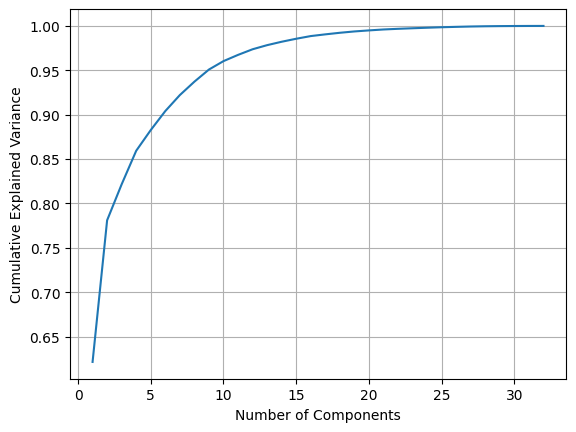

In [63]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Analyze explained variance
pca = PCA()
pca.fit(X_agg_scaled)
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid()
plt.show()

# Choose an appropriate value for n_components and apply PCA
n_components = 20  # Adjust this value based on the explained variance analysis
pca = PCA(n_components=n_components)
X = pca.fit_transform(X_agg_scaled)

### **MODEL WITH PCA**

In [72]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

input_shape = (20,)
num_classes = y.shape[1]

model = Sequential()

# Add dense layers
model.add(Dense(512, activation="relu", input_shape=input_shape))
model.add(Dropout(0.5))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(num_classes, activation="softmax"))

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 512)               10752     
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 144,136
Trainable params: 144,136
Non-trainable params: 0
_________________________________________________________________


In [73]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Split the data into training, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.12, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

# Train the model
batch_size = 32
epochs = 150
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/150
64/64 [==============================] - 2s 6ms/step - loss: 2.0024 - accuracy: 0.2210 - val_loss: 1.7865 - val_accuracy: 0.3570
Epoch 2/150
64/64 [==============================] - 0s 3ms/step - loss: 1.7631 - accuracy: 0.3217 - val_loss: 1.6543 - val_accuracy: 0.3984
Epoch 3/150
64/64 [==============================] - 0s 3ms/step - loss: 1.6485 - accuracy: 0.3809 - val_loss: 1.5515 - val_accuracy: 0.4497
Epoch 4/150
64/64 [==============================] - 0s 3ms/step - loss: 1.5467 - accuracy: 0.4282 - val_loss: 1.4985 - val_accuracy: 0.4576
Epoch 5/150
64/64 [==============================] - 0s 3ms/step - loss: 1.4937 - accuracy: 0.4317 - val_loss: 1.4581 - val_accuracy: 0.4852
Epoch 6/150
64/64 [==============================] - 0s 3ms/step - loss: 1.4535 - accuracy: 0.4509 - val_loss: 1.4295 - val_accuracy: 0.4892
Epoch 7/150
64/64 [==============================] - 0s 3ms/step - loss: 1.4001 - accuracy: 0.4721 - val_loss: 1.3879 - val_accuracy: 0.5049
Epoch 8/150
6

11/11 [==============================] - 0s 2ms/step - loss: 0.9878 - accuracy: 0.7168
Test accuracy: 0.72


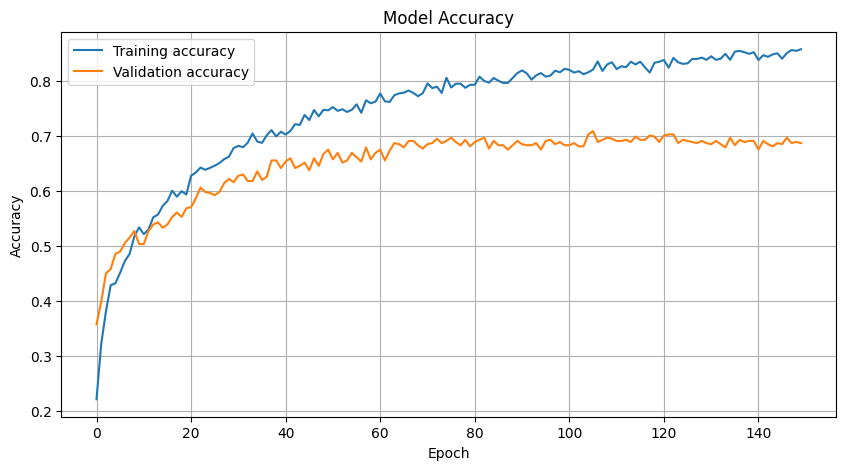

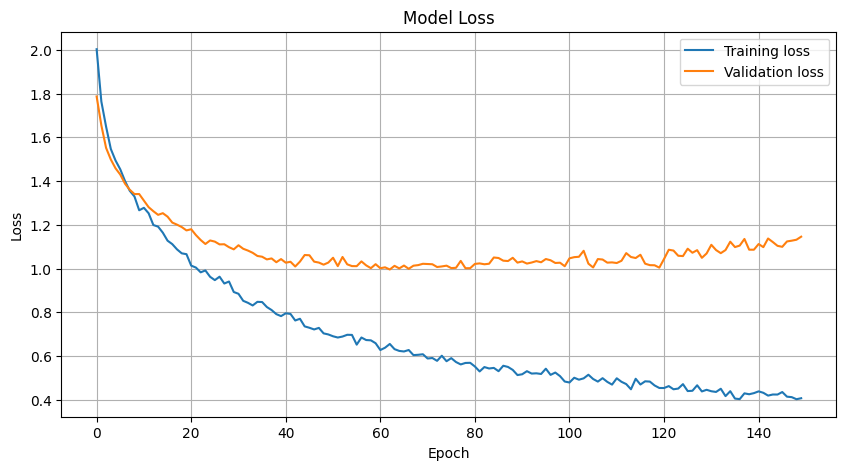

In [74]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.2f}")

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history["accuracy"], label="Training accuracy")
plt.plot(history.history["val_accuracy"], label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy")
plt.grid()
plt.show()

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss")
plt.grid()
plt.show()

11/11 [==============================] - 0s 1ms/step


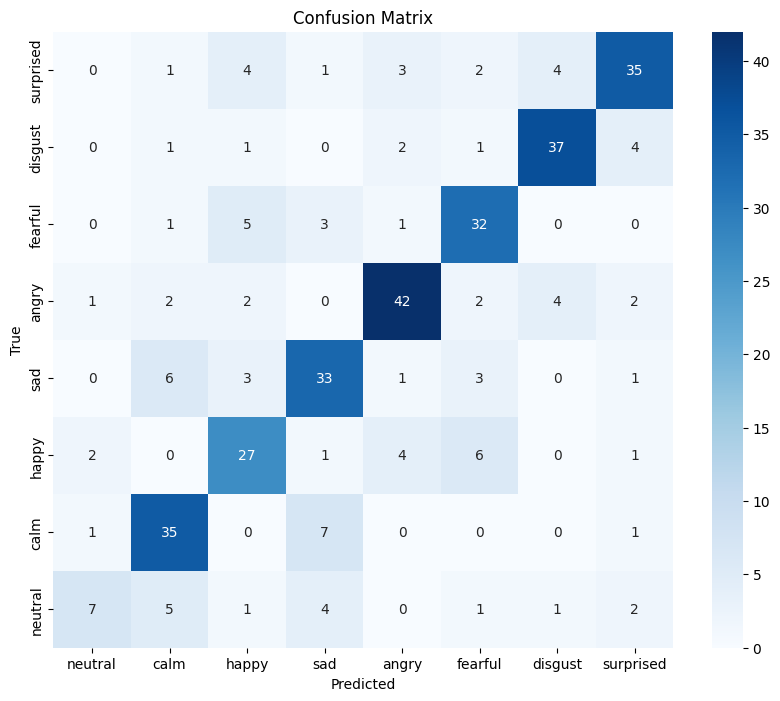

In [76]:
from sklearn.metrics import confusion_matrix
# Next, make predictions using the test set
y_pred = model.predict(X_test)

# Get the indices of the maximum values in y_pred and y_test (corresponding to the predicted and true labels, respectively)
y_pred_indices = np.argmax(y_pred, axis=1)
y_test_indices = np.argmax(y_test, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test_indices, y_pred_indices)

# Reorder the confusion matrix, if necessary
cm_reordered = cm[::-1, :]

# Define the emotion labels
emotion_labels = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm_reordered, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=emotion_labels, yticklabels=emotion_labels[::-1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [77]:
from sklearn.metrics import classification_report

# Calculate the classification report
report = classification_report(y_test_indices, y_pred_indices)
print('0 - neutral | ', '1 - calm | ', '2 - happy | ', '3 - sad | ', '4 - angry | ', '5 - fearful | ', '6 - disgust | ', '7 - surprised\n')
print(report)

0 - neutral |  1 - calm |  2 - happy |  3 - sad |  4 - angry |  5 - fearful |  6 - disgust |  7 - surprised

              precision    recall  f1-score   support

           0       0.64      0.33      0.44        21
           1       0.69      0.80      0.74        44
           2       0.63      0.66      0.64        41
           3       0.67      0.70      0.69        47
           4       0.79      0.76      0.78        55
           5       0.68      0.76      0.72        42
           6       0.80      0.80      0.80        46
           7       0.76      0.70      0.73        50

    accuracy                           0.72       346
   macro avg       0.71      0.69      0.69       346
weighted avg       0.72      0.72      0.71       346



## **====================================================================================================================================================================================================================================**

### **OLD MODEL BELOW::**

### **Model**

In [70]:
X.shape

(2880, 20)

In [67]:
y.shape

(2880, 8)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [115]:
# Calculate the input shape (number of features)
input_shape = X_train.shape[1], X_train.shape[2]

In [43]:
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Reshape
import keras
from tensorflow.keras.regularizers import l1, l2, l1_l2
"""
model = Sequential([
    Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=256, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])
"""
model = Sequential([
    Reshape((32, 495), input_shape=(32, 495)),
    Conv1D(filters=256, kernel_size=5, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=512, kernel_size=5, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    #Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
    #MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    #Dense(64, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(learning_rate = 0.0001),metrics=['accuracy'])

In [ ]:
#CNN
#early_stopping = EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True)

In [44]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=350, batch_size=32)

Epoch 1/350


ValueError: ignored

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

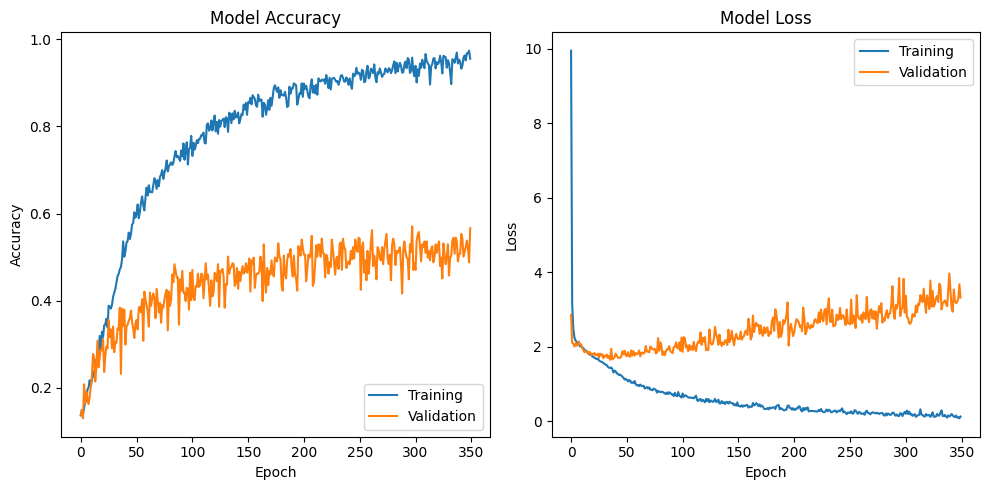

In [119]:
# Plot training & validation accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

18/18 [==============================] - 0s 2ms/step


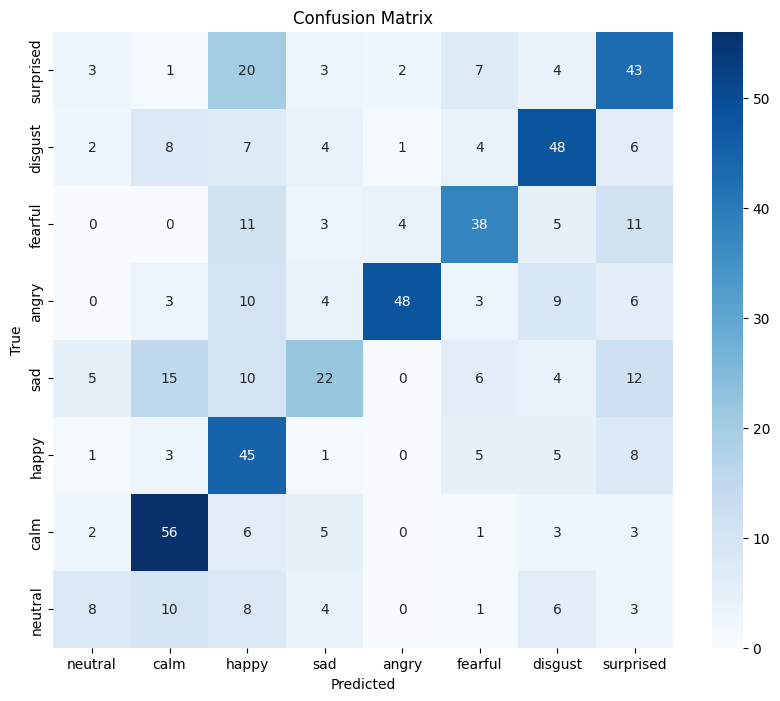

In [120]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)

y_pred_indices = np.argmax(y_pred, axis=1)
y_test_indices = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_indices, y_pred_indices)

cm_reordered = cm[::-1, :]

emotion_labels = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

plt.figure(figsize=(10, 8))
sns.heatmap(cm_reordered, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=emotion_labels, yticklabels=emotion_labels[::-1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [121]:
from sklearn.metrics import classification_report

# Calculate the classification report
report = classification_report(y_test_indices, y_pred_indices)
print('0 - neutral | ', '1 - calm | ', '2 - happy | ', '3 - sad | ', '4 - angry | ', '5 - fearful | ', '6 - disgust | ', '7 - surprised\n')
print(report)

0 - neutral |  1 - calm |  2 - happy |  3 - sad |  4 - angry |  5 - fearful |  6 - disgust |  7 - surprised

              precision    recall  f1-score   support

           0       0.38      0.20      0.26        40
           1       0.58      0.74      0.65        76
           2       0.38      0.66      0.49        68
           3       0.48      0.30      0.37        74
           4       0.87      0.58      0.70        83
           5       0.58      0.53      0.55        72
           6       0.57      0.60      0.59        80
           7       0.47      0.52      0.49        83

    accuracy                           0.53       576
   macro avg       0.54      0.52      0.51       576
weighted avg       0.56      0.53      0.53       576



### **Hyperparameter Tuning**

In [75]:
def build_model1(hp):
    model = Sequential([
        Reshape((32, 495), input_shape=(32, 495)),
        Conv1D(filters=hp.Int("conv_1_filters", min_value=64, max_value=512, step=64), kernel_size=5, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=hp.Int("conv_2_filters", min_value=64, max_value=512, step=64), kernel_size=5, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        #Conv1D(filters=hp.Int("conv_3_filters", min_value=128, max_value=512, step=128), kernel_size=3, activation='relu', padding='same'),
        #MaxPooling1D(pool_size=2),
        Dropout(0.2),
        Flatten(),
        Dense(hp.Int("dense_1_units", min_value=128, max_value=512, step=64), activation='relu'),
        Dense(hp.Int("dense_2_units", min_value=64, max_value=256, step=32), activation='relu'),
        #Dense(hp.Int("dense_3_units", min_value=32, max_value=128, step=16), activation='relu'),
        Dense(y_train.shape[1], activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice("learning_rate", values=[1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [76]:
import keras_tuner as kt
tuner1 = kt.RandomSearch(
    build_model1,
    objective='val_accuracy',
    max_trials=50,  
    directory='my_directory1',
    project_name='cnn_hyperparameter_tuning'
)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

In [77]:
# Run the hyperparameter search
tuner1.search(X_train, y_train, epochs=60, validation_data=(X_val, y_val), callbacks=[early_stopping])

Trial 50 Complete [00h 00m 20s]
val_accuracy: 0.3784722089767456

Best val_accuracy So Far: 0.4114583432674408
Total elapsed time: 00h 14m 04s


In [78]:
# Get the best model
best_model = tuner1.get_best_models(num_models=1)[0]

# Print the best hyperparameters
best_hyperparameters = tuner1.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:", best_hyperparameters)

Best hyperparameters: <keras_tuner.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7f55b49dd8b0>


In [79]:
best_hp = tuner1.get_best_hyperparameters(num_trials=1)[0]

for hp in best_hp.space:
    hp_name = hp.name
    hp_value = best_hp.get(hp_name)
    print(f"{hp_name}: {hp_value}")

conv_1_filters: 128
conv_2_filters: 320
dense_1_units: 384
dense_2_units: 160
learning_rate: 0.0001


### **Using the Best Parameters**

In [81]:
def build_model1():
    model = Sequential([
        Reshape((32, 495), input_shape=(32, 495)),
        Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'),
        MaxPooling1D(pool_size=3),
        Conv1D(filters=320, kernel_size=5, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        #Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
        #MaxPooling1D(pool_size=2),
        Dropout(0.2),
        Flatten(),
        Dense(384, activation='relu'),
        Dense(160, activation='relu'),
        #Dense(96, activation='relu'),
        Dense(y_train.shape[1], activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [82]:
# Build the model
model = build_model1()

# Create a ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=30, verbose=1, min_lr=1e-4)

# Train the model with the callback
history = model.fit(X_train, y_train,
                    epochs=350,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[reduce_lr],
                    verbose=2)

Epoch 1/350
54/54 - 2s - loss: 11.7352 - accuracy: 0.1215 - val_loss: 2.7235 - val_accuracy: 0.1406 - lr: 1.0000e-04 - 2s/epoch - 45ms/step
Epoch 2/350
54/54 - 0s - loss: 3.5639 - accuracy: 0.1372 - val_loss: 2.1243 - val_accuracy: 0.1667 - lr: 1.0000e-04 - 265ms/epoch - 5ms/step
Epoch 3/350
54/54 - 0s - loss: 2.4206 - accuracy: 0.1505 - val_loss: 2.0055 - val_accuracy: 0.2135 - lr: 1.0000e-04 - 264ms/epoch - 5ms/step
Epoch 4/350
54/54 - 0s - loss: 2.2290 - accuracy: 0.1696 - val_loss: 2.1136 - val_accuracy: 0.1615 - lr: 1.0000e-04 - 264ms/epoch - 5ms/step
Epoch 5/350
54/54 - 0s - loss: 2.1054 - accuracy: 0.1973 - val_loss: 1.9677 - val_accuracy: 0.2674 - lr: 1.0000e-04 - 270ms/epoch - 5ms/step
Epoch 6/350
54/54 - 0s - loss: 2.0434 - accuracy: 0.1898 - val_loss: 2.0263 - val_accuracy: 0.2135 - lr: 1.0000e-04 - 261ms/epoch - 5ms/step
Epoch 7/350
54/54 - 0s - loss: 2.0137 - accuracy: 0.2106 - val_loss: 1.9204 - val_accuracy: 0.2101 - lr: 1.0000e-04 - 263ms/epoch - 5ms/step
Epoch 8/350
54

18/18 [==============================] - 0s 3ms/step - loss: 3.2694 - accuracy: 0.5295
Test accuracy: 0.5295138955116272


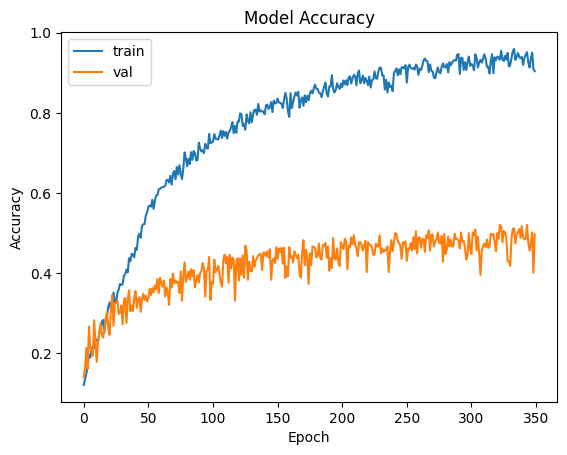

In [83]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

18/18 [==============================] - 0s 2ms/step


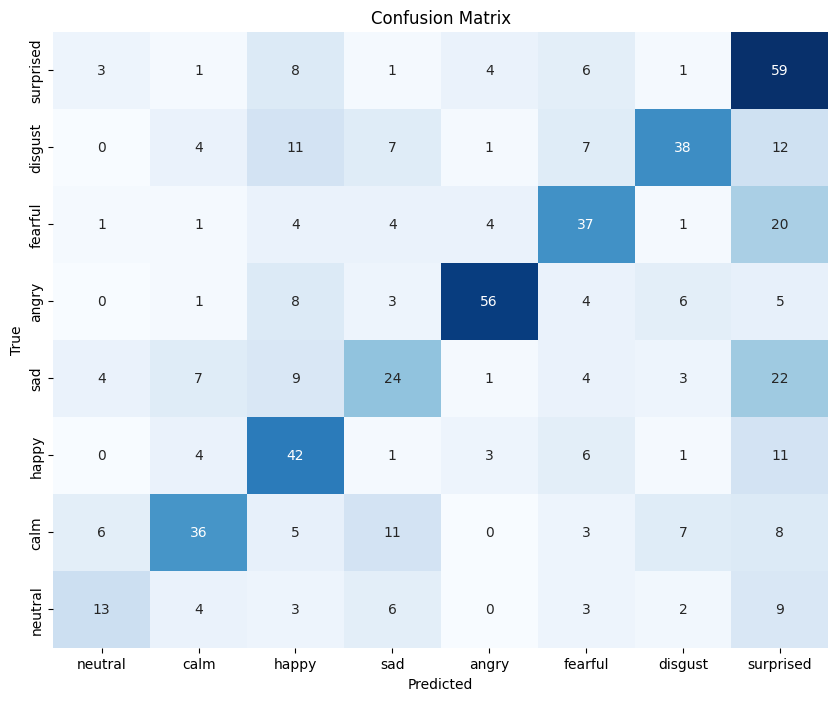

In [84]:
y_pred = model.predict(X_test)

y_pred_indices = np.argmax(y_pred, axis=1)
y_test_indices = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_indices, y_pred_indices)

cm_reordered = cm[::-1, :]

emotion_labels = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

plt.figure(figsize=(10, 8))
sns.heatmap(cm_reordered, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=emotion_labels, yticklabels=emotion_labels[::-1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [85]:
from sklearn.metrics import classification_report

# Calculate the classification report
report = classification_report(y_test_indices, y_pred_indices)
print('0 - neutral | ', '1 - calm | ', '2 - happy | ', '3 - sad | ', '4 - angry | ', '5 - fearful | ', '6 - disgust | ', '7 - surprised\n')
print(report)

0 - neutral 1 - calm 2 - happy 3 - sad 4 - angry 5 - fearful 6 - disgust 7 - surprised

              precision    recall  f1-score   support

           0       0.48      0.33      0.39        40
           1       0.62      0.47      0.54        76
           2       0.47      0.62      0.53        68
           3       0.42      0.32      0.37        74
           4       0.81      0.67      0.74        83
           5       0.53      0.51      0.52        72
           6       0.64      0.47      0.55        80
           7       0.40      0.71      0.52        83

    accuracy                           0.53       576
   macro avg       0.55      0.51      0.52       576
weighted avg       0.56      0.53      0.53       576

